In [2]:
!pip install tensorflow tensorflow-datasets matplotlib ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00


In [3]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Dense, Flatten, LeakyReLU, Reshape, Dropout, UpSampling2D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import History
import datetime

In [4]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

## Project Overview

In this project we'll be building a GAN to generate images of a variety of vehicles and animals, based on the stl10 dataset, which contains images of birds, airplanes, ships, cats, trucks, ships, airplanes, cars, deers, and horses.

To achieve this we will create a Generator that outputs images, using a number of CNN layers, upsampling layers, and an output layer, and conversely, a Discriminator, which will be trained to discriminate between real images and generated images.

### STL-10 Database (Source: https://www.tensorflow.org/datasets/catalog/stl10)
The STL-10 dataset is an image recognition dataset for developing unsupervised feature learning, deep learning, self-taught learning algorithms. It is inspired by the CIFAR-10 dataset but with some modifications. In particular, each class has fewer labeled training examples than in CIFAR-10, but a very large set of unlabeled examples is provided to learn image models prior to supervised training. All images were acquired from labeled examples on ImageNet.

Note: For our purposes, the labels will actually not be necessary, since our goal is not to generate images of a specific type, but simply to create images that pass as real.

### Update:

As you'll see below, our model struggled to fit with such high resolution images, so you'll also see references to actually importing and trying different models with cifar10 (source: https://www.tensorflow.org/datasets/catalog/cifar10)



In [5]:
# Setup GPU
print("TensorFlow version:", tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')

print("Num GPUs Available: ", len(gpus))

# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

TensorFlow version: 2.15.0
Num GPUs Available:  1
Sun Jul  7 00:00:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              44W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------

In [4]:
# Use tensorflow-datasets to import from tensorflow.org
# ds = tfds.load('stl10',  split='unlabelled') # split options train=5,000 images, other options include 'test'=8000 images, and 'unlabelled'=100,000 images

# Using cifar10 instead, see note below

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.EUURA1_1.0.0/stl10-train.tfrecord*...:   0%|          | 0…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.EUURA1_1.0.0/stl10-test.tfrecord*...:   0%|          | 0/…

Generating unlabelled examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.EUURA1_1.0.0/stl10-unlabelled.tfrecord*...:   0%|        …

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


# A note about datasets

This model was attempted with the stl10 dataset, which proved to be far too time consuming for even the most powerful GPU in google colab.  Instead, let's try a very similar dataset, but at a much lower resolution.  And maybe even convert it to greyscale

In [6]:
ds = tfds.load('cifar10',  split='train')

def convert_to_grayscale(element):
    image = element['image']
    label = element['label']
    # Convert the image to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return {'image': grayscale_image, 'label': label}

ds = ds.map(convert_to_grayscale)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.4P58U2_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.4P58U2_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


# Visualizing the data

Let's take a peak at our data to see what we're working with

In [7]:
# Visualizing the dataset
data_iterator = ds.as_numpy_iterator() # This data_iterator essentially a pipeline that we can use to pull in images, as we need them

# We can call...
data_iterator.next() # To get a new image

{'image': array([[[107],
         [106],
         [103],
         ...,
         [ 52],
         [ 58],
         [ 55]],
 
        [[106],
         [125],
         [151],
         ...,
         [ 61],
         [ 62],
         [ 60]],
 
        [[ 77],
         [103],
         [166],
         ...,
         [ 83],
         [ 78],
         [ 75]],
 
        ...,
 
        [[158],
         [156],
         [150],
         ...,
         [170],
         [173],
         [180]],
 
        [[157],
         [151],
         [145],
         ...,
         [171],
         [175],
         [178]],
 
        [[167],
         [160],
         [159],
         ...,
         [184],
         [192],
         [194]]], dtype=uint8),
 'label': 7}

Number of images: 50000


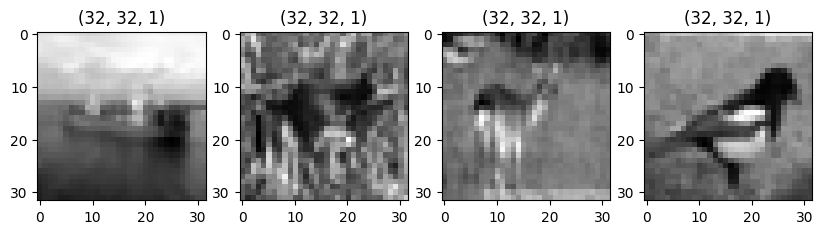

In [142]:
print(f"Number of images: {len(ds)}")

# Display a batch of 4 images
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for index in range(4):
    example = data_iterator.next() # set example to an image
    ax[index].imshow(example['image'], cmap='gray') # Add image to subplot
    ax[index].title.set_text(example['image'].shape) # Display image shape

## Data analysis and pipeline preperation

As we you can see, we have 50000 images with a variety of content, all of which are 96x96 pixels, and a 3 channel RGB dimension.

Next up, we will prepare/transform our dataset pipeline to help our model perform better

In [143]:
# Normalize our RGB channel from 0-255 to 0-1, so that our network trains better/faster
def normalize(data):
    image = data['image']
    return image / 255
dataset = ds.map(normalize) # scale images

dataset = dataset.cache() # Cache for performance
dataset = dataset.shuffle(1000) # Shuffle to ensure randomness
# Batching and prefetch helps the dataset preload to avoid bottlenecks
dataset = dataset.batch(128)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Check batch size.  Should be 128 images x (96x96x3)
dataset.as_numpy_iterator().next().shape

(128, 32, 32, 1)

### Model Creation

Next we will create a generator and discriminator model.  The generator will be taking in random values and attempting to create fake images and the discriminator will be trained to spot the fakes

#### Building a Generator

Below you'll find two models.  An older one, which I did not have much success with due to resource constaints.  And a new one for the simpler dataset.

The new model required less upsampling steps, and uses a bigger kernal during CNN training

In [8]:
# Generator

# OLD MODEL for larger 96x96 images
# def build_generator():
#     model = Sequential() # Create a sequential model

#     model.add(Input(shape=(128,)))  # Specify the input shape

#     # Dense layer to map the latent space to a 6x6x128 feature map
#     model.add(Dense(6 * 6 * 128)) # Latent space dimension of 128, eventually mapped across a 6x6 image (below)
#     model.add(LeakyReLU(.2)) # Activation function
#     model.add(Reshape((6,6,128))) # Reshape the dense layer to a 6x6

#     # Upsample to 12x12
#     model.add(UpSampling2D()) # Double spatial dimension to 12x12x128
#     model.add(Conv2D(128, 3, padding='same')) # 3x3 kernal
#     model.add(LeakyReLU(.2)) # Activation function

#     # Upsample again to 24x24
#     model.add(UpSampling2D()) # Double spatial dimension to 24x24x128
#     model.add(Conv2D(128, 3, padding='same'))
#     model.add(LeakyReLU(.2)) # Activation function

#     # Upsample again to 48x48
#     model.add(UpSampling2D()) # Double spatial dimension to 48x48x128
#     model.add(Conv2D(128, 3, padding='same'))
#     model.add(LeakyReLU(.2)) # Activation function

#     # Upsample again to 96x96
#     model.add(UpSampling2D()) # Double spatial dimension to 96x96x128
#     model.add(Conv2D(128, 3, padding='same'))
#     model.add(LeakyReLU(.2)) # Activation function

#     # CNN block with same output shape to refine features
#     model.add(Conv2D(128, 3, padding='same'))
#     model.add(LeakyReLU(.2))

#     # CNN block with same output shape to refine features
#     model.add(Conv2D(128, 3, padding='same'))
#     model.add(LeakyReLU(.2))

#     # CNN Layer to get back to RGB image
#     model.add(Conv2D(3, 3, padding='same', activation='sigmoid'))

#     return model

# NEW MODEL for 24x24 images
def build_generator():
    model = Sequential() # Create a sequential model

    model.add(Input(shape=(128,)))  # Specify the input shape

    # Dense layer to map the latent space to a 6x6x128 feature map
    model.add(Dense(8 * 8 * 128)) # Latent space dimension of 128, eventually mapped across a 6x6 image (below)
    model.add(LeakyReLU(.2)) # Activation function
    model.add(Reshape((8,8,128))) # Reshape the dense layer to a 6x6

    # Upsample to 16x16
    model.add(UpSampling2D()) # Double spatial dimension to 16x16x128
    model.add(Conv2D(128, 5, padding='same')) # 5x5 kernal
    model.add(LeakyReLU(.2)) # Activation function

    # Upsample again to 32x32
    model.add(UpSampling2D()) # Double spatial dimension to 32x32x128
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(.2)) # Activation function

    # CNN block with same output shape to refine features
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(.2))

    # CNN block with same output shape to refine features
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(.2))

    # CNN Layer to get back to greyscale image
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

test_gen_model = build_generator()
test_gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 16, 16, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                        

1/1 [==============================] - 0s 230ms/step
[[[[0.49838552]
   [0.49724153]
   [0.49897572]
   ...
   [0.5002857 ]
   [0.49961883]
   [0.50183815]]

  [[0.49727616]
   [0.50153273]
   [0.5039916 ]
   ...
   [0.5001003 ]
   [0.496029  ]
   [0.50077695]]

  [[0.50308686]
   [0.5061065 ]
   [0.5067101 ]
   ...
   [0.50545824]
   [0.50278366]
   [0.5034635 ]]

  ...

  [[0.5028902 ]
   [0.4988168 ]
   [0.5042354 ]
   ...
   [0.5007949 ]
   [0.50418144]
   [0.505921  ]]

  [[0.49931312]
   [0.5017569 ]
   [0.50526446]
   ...
   [0.500845  ]
   [0.5042251 ]
   [0.5061777 ]]

  [[0.5000359 ]
   [0.49643508]
   [0.5025098 ]
   ...
   [0.50459206]
   [0.50564986]
   [0.5042278 ]]]


 [[[0.49759963]
   [0.50217897]
   [0.50407773]
   ...
   [0.5021723 ]
   [0.5027857 ]
   [0.4994822 ]]

  [[0.50300133]
   [0.502391  ]
   [0.50058645]
   ...
   [0.49986914]
   [0.50064075]
   [0.5018727 ]]

  [[0.50358796]
   [0.5000093 ]
   [0.5015729 ]
   ...
   [0.5077848 ]
   [0.5046778 ]
   [0.50350

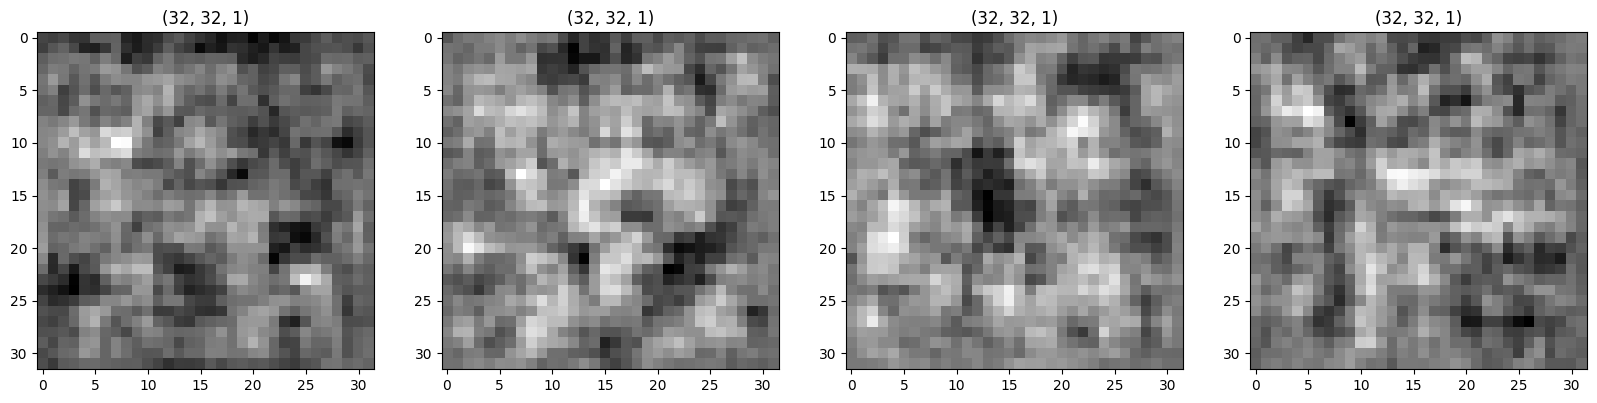

In [177]:
# Testing the image generator so far...

random_input = np.random.randn(4, 128, 1)
images = test_gen_model.predict(random_input)
# print(images)

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for index in range(len(images)):
    example = images[index] # set example to an image
    ax[index].imshow(example, cmap='gray') # Add image to subplot
    ax[index].title.set_text(example.shape) # Display image shape

#### Create a discriminator

Similarly, you'll see the first model I tried, and the new model below it

In [178]:
# def build_discriminator():
#     model = Sequential()

#     model.add(Input(shape=(96,96,3)))  # Specify the input shape

#     model.add(Conv2D(32, 3))  # input shape should be the same as the output of our generator
#     model.add(LeakyReLU(.2)) # Leaky ReLU is the recommended activation function for GANS
#     model.add(Dropout(.5)) # Add some regularization

#     model.add(Conv2D(64, 3))
#     model.add(LeakyReLU(.2))
#     model.add(Dropout(.5))

#     model.add(Conv2D(128, 3))
#     model.add(LeakyReLU(.2))
#     model.add(Dropout(.5))

#     model.add(Conv2D(256, 3))
#     model.add(LeakyReLU(.2))
#     model.add(Dropout(.5))

#     model.add(Flatten())
#     model.add(Dropout(.5))
#     model.add(Dense(1, activation='sigmoid')) # 1 will represent a false image and 0 will represent a true image


#     return model

def build_discriminator():
    model = Sequential()

    model.add(Input(shape=(32,32,1)))  # Main difference is that the input shape has been updated

    model.add(Conv2D(32, 5))
    model.add(LeakyReLU(.2))
    model.add(Dropout(.4)) # Also decreased dropout

    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(.2))
    model.add(Dropout(.4))

    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(.2))
    model.add(Dropout(.4))

    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(.2))
    model.add(Dropout(.4))

    model.add(Flatten())
    model.add(Dropout(.4))
    model.add(Dense(1, activation='sigmoid')) # 1 will represent a false image and 0 will represent a true image


    return model

test_discrim_model = build_discriminator()

test_discrim_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_150 (Conv2D)         (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_153 (LeakyReLU  (None, 30, 30, 32)        0         
 )                                                               
                                                                 
 dropout_75 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_151 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 leaky_re_lu_154 (LeakyReLU  (None, 28, 28, 64)        0         
 )                                                               
                                                                 
 dropout_76 (Dropout)        (None, 28, 28, 64)      

In [179]:
# Discriminator example usage

test_discrim_model.predict(images)

1/1 [==============================] - 0s 207ms/step


array([[0.50708514],
       [0.5069499 ],
       [0.5074498 ],
       [0.50738585]], dtype=float32)

### Check-in

With the generator and discriminator built, we can see above that the generator takes an input of 128 random values and generate an image in the shape 32x32x1, and the discriminator is going to take an image and output a 1 or 0 for false or true images.

Next, we'll want to train our models, the main challenge being striking a good balance between our generator and discriminator

In [181]:
class GAN(Model):
    def __init__(self, gen_model, dis_model, *args, **kwargs): # Initialization function
        super().__init__(*args, **kwargs) # Takes any additional arguments

        # Take generator and discriminator models which have already be instantiated
        self.gen_model = gen_model
        self.dis_model = dis_model

    def compile(self, gen_opt, dis_opt, gen_loss, dis_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.gen_opt = gen_opt
        self.dis_opt = dis_opt
        self.gen_loss = gen_loss
        self.dis_loss = dis_loss

    def train_step(self, batch): # Called when you call .fit
        # First thing we need to take in is our batch of images
        batch_size = 128
        latent_space = 128
        real_images = batch
        fake_images = self.gen_model(tf.random.normal((batch_size, latent_space)), training=False)

        # Train discriminator
        with tf.GradientTape() as d_tape: # Record the operations and compute the gradients of the discriminator loss with respect to the discriminator’s trainable variables
            # yhat_ vars are predictions from our discriminator
            yhat_real = self.dis_model(real_images, training=True) # Pass real images into the discriminator. training=True to engage dropout layers
            yhat_fake = self.dis_model(fake_images, training=True) # Pass in fake images to discrim
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0) # Concatenate results

            # Create labels for real/fake concatenated together
            y_realfake = tf.concat([
                tf.zeros_like(yhat_real), # Set all real values to 0
                tf.ones_like(yhat_fake)] # Set all fakes to label=1
            , axis=0)

            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real)) # Add some small value to our real (0) output
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake)) # Subject small value from our fake (-1) output
            y_realfake += tf.concat([noise_real, noise_fake], axis=0) # add each element of y_realfake with the noise value

            # Loss function
            total_dis_loss = self.dis_loss(y_realfake, yhat_realfake) # This will be binary cross entropy

        # Backpropagation
        dis_gradient = d_tape.gradient(total_dis_loss, self.dis_model.trainable_variables)
        self.dis_opt.apply_gradients(zip(dis_gradient, self.dis_model.trainable_variables))

        # Train Generator
        with tf.GradientTape() as g_tape:
            # Create images
            generated_images = self.gen_model(tf.random.normal((batch_size, latent_space, 1)), training=True)

            # Label images with discriminator output
            predicted_labels = self.dis_model(generated_images, training=False) # Don't train the discriminator while giving generator predictions

            total_gen_loss = self.gen_loss(tf.zeros_like(predicted_labels), predicted_labels) # Loss function based on fooling the discriminator

        # Backpropagation for generator
        gen_gradient = g_tape.gradient(total_gen_loss, self.gen_model.trainable_variables)
        self.gen_opt.apply_gradients(zip(gen_gradient, self.gen_model.trainable_variables))

        return {"dis_loss": total_dis_loss, "gen_loss": total_gen_loss}

# Note on hyperparameters

I played around with the noise rate in the Discriminator training function when the model was failing to improve.  I started at .15 and -.15 * a random distribution, but was only getting black images after 120+ epochs.  Moved it to .35 and -.35 to induce more randomness, but only had a short term effect on loss which quickly leveled off.  Returning back to .15 and -.15 for more stability

In [182]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128, save_freq=3):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_freq = save_freq  # Save images every 'save_freq' epochs

        # Create directory if it doesn't exist
        if not os.path.exists('images24x24'):
            os.makedirs('images24x24')

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.save_freq == 0:
            random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))  # Generate random values
            generated_images = self.model.gen_model(random_latent_vectors)  # Pass it into the generator
            generated_images = generated_images * 255.0  # Scale images to 0-255
            generated_images = tf.clip_by_value(generated_images, 0, 255)  # Clip values to be in the valid range
            generated_images = tf.cast(generated_images, tf.uint8)  # Convert to uint8 type

            for i in range(self.num_img):
                img = array_to_img(generated_images[i].numpy())
                img.save(os.path.join('images24x24', f"generated_img_{epoch}_{i}.png"))


### Training the GAN model

Now it's time to create an instance of our GAN model and train it

In [251]:
# Setup loss functions and optimizers

# Create optomizers for generator and discriminator
# gen_optimizer = Adam(learning_rate=0.0001) # Have our generator learn faster so that discriminator is not too strong from the start
# dis_optimizer = Adam(learning_rate=0.00001)

# Create losses for generator and discriminator
# gen_loss = BinaryCrossentropy()
# dis_loss = BinaryCrossentropy()

# Trying different loss functions
gen_loss = BinaryCrossentropy()
dis_loss = BinaryCrossentropy()

gen_optimizer = Adam(learning_rate=0.0001) # Have our generator learn faster so that discriminator is not too strong from the start
dis_optimizer = Adam(learning_rate=0.00001)

# Note on learning rate

I tried a few different learning rates and this seems really difficult to get right.  If the discriminator is too strong too quickly, the generator will fail to make any meaningful progress.  In this setup, the discriminator learns 10x slower than than the generator

In [9]:
generator = build_generator() # Create fresh new generator

In [241]:
# generator = tf.keras.models.load_model('generator.keras') # Load work in progress model
discriminator = build_discriminator() # Create fresh new discriminator
# discriminator = tf.keras.models.load_model('discriminator.keras') # Load work in progres model

gan = GAN(generator, discriminator) # Instantiate model initially

# Restore the checkpoint
# checkpoint_dir = './training_checkpoints'
# checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer2,
#                                  discriminator_optimizer=dis_optimizer2,
#                                  generator=generator,
#                                  discriminator=discriminator)

# Restore the latest checkpoint
# latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
# checkpoint.restore(latest_checkpoint).assert_existing_objects_matched()

# Recompile the GAN model with the loaded optimizers
# gan.compile(optimizer=[gen_optimizer, dis_optimizer], loss='binary_crossentropy') # Initial

gan.compile(gen_opt=gen_optimizer, dis_opt=dis_optimizer, gen_loss=gen_loss, dis_loss=dis_loss)

In [242]:
# # Create new history object
# final_history = History()

# # Check if history file exists
# history_file = 'history.json'
# if os.path.exists(history_file):
#   with open(history_file, 'r') as f:
#     history_data = json.load(f)

#   # And append data to final_history
#   final_history.history = history_data['history']
#   final_history.epoch = history_data['epoch']
#   final_history.params = history_data['params']

In [243]:
history = gan.fit(dataset, epochs=30, callbacks=[ModelMonitor()]) # Initial run

Epoch 1/30
391/391 [==============================] - 19s 38ms/step - dis_loss: 0.5703 - gen_loss: 2.1367
Epoch 2/30
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2892 - gen_loss: 7.5436
Epoch 3/30
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2842 - gen_loss: 6.5582
Epoch 4/30
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2817 - gen_loss: 5.5550
Epoch 5/30
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2796 - gen_loss: 4.6433
Epoch 6/30
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2777 - gen_loss: 3.8634
Epoch 7/30
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2755 - gen_loss: 3.2391
Epoch 8/30
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2736 - gen_loss: 2.7662
Epoch 9/30
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2729 - gen_loss: 2.3874
Epoch 10/30
391/391 [=========================

In [258]:
additional_epochs = 1000
history_continued = gan.fit(dataset, epochs=additional_epochs, callbacks=[ModelMonitor()])

#Code for saving state of model to continue learning

history.history['dis_loss'].extend(history_continued.history['dis_loss'])
history.history['gen_loss'].extend(history_continued.history['gen_loss'])
history.params['epochs'] += additional_epochs

Epoch 1/1000
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2671 - gen_loss: 0.7623
Epoch 2/1000
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2664 - gen_loss: 0.7720
Epoch 3/1000
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2669 - gen_loss: 0.7655
Epoch 4/1000
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2668 - gen_loss: 0.7663
Epoch 5/1000
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2665 - gen_loss: 0.7793
Epoch 6/1000
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2670 - gen_loss: 0.7788
Epoch 7/1000
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2671 - gen_loss: 0.7673
Epoch 8/1000
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2672 - gen_loss: 0.7670
Epoch 9/1000
391/391 [==============================] - 15s 38ms/step - dis_loss: 0.2662 - gen_loss: 0.7662
Epoch 10/1000
391/391 [=====

In [245]:

# # Get the current date and time
# now = datetime.datetime.now()

# # Format the date and time for use in the filename
# formatted_date_time = now.strftime("%Y%m%d_%H%M%S")

# # Save the model using the formatted date and time as part of the filename
# generator.save(f"generator_{formatted_date_time}.keras") # Save a timestamped version in case something goes wrong
# generator.save("generator.keras")
# discriminator.save(f"discriminator_{formatted_date_time}.keras")
# discriminator.save('discriminator.keras')
# # gan.save(f"gan_{formatted_date_time}.keras")

# # Create a checkpoint directory
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

# # Create a checkpoint
# checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer2,
#                                  discriminator_optimizer=dis_optimizer2,
#                                  generator=generator,
#                                  discriminator=discriminator)

# # Save the checkpoint
# checkpoint.save(file_prefix=checkpoint_prefix)

In [246]:
# import json

# history_data = {
#     'history': final_history.history,
#     'epoch': final_history.epoch,
#     'params': final_history.params
# }
# with open('history.json', 'w') as f:
#     json.dump(history_data, f)

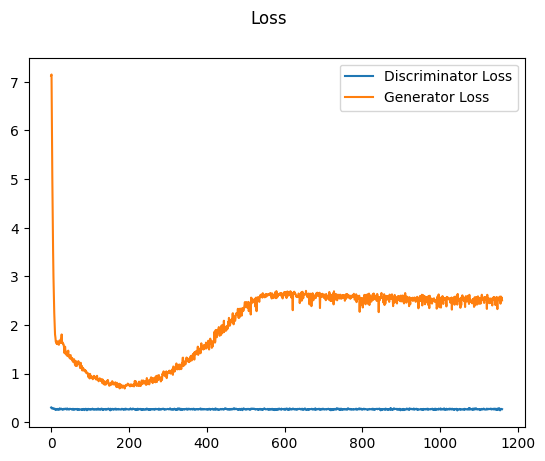

In [259]:
# Display a graph showing loss over time
plt.suptitle('Loss')
plt.plot(history.history['dis_loss'], label='Discriminator Loss')
plt.plot(history.history['gen_loss'], label='Generator Loss')
plt.legend()
plt.show()

### Note above losses above

The drop in loss was from an adjustment in the noise hyperparameters, but it appears to be leveling off.

1/1 [==============================] - 2s 2s/step
(16, 32, 32, 1)


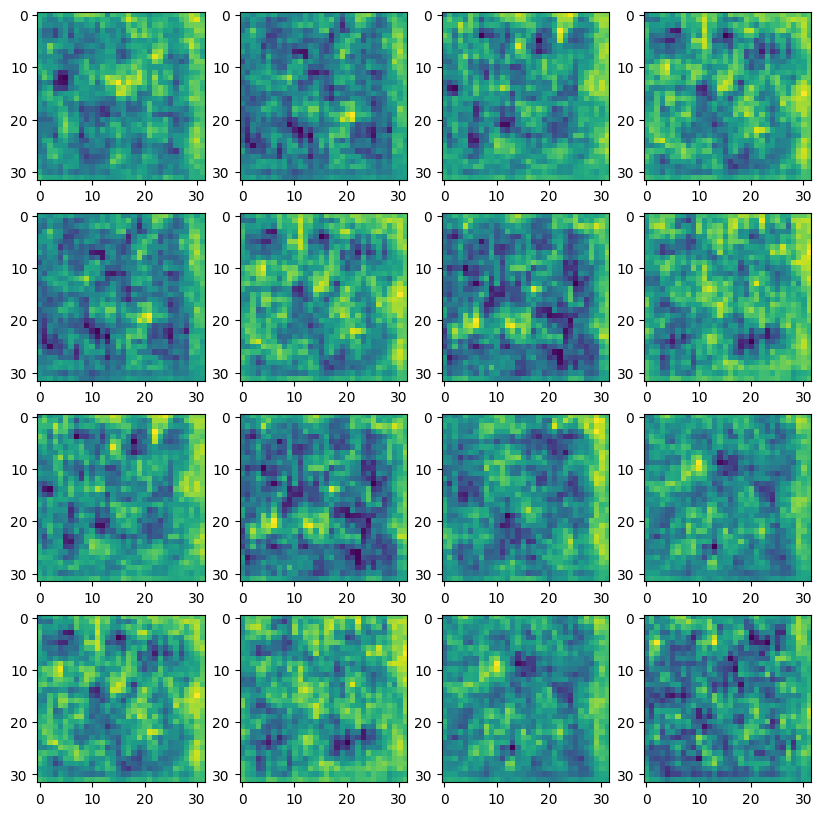

In [10]:
# Generate images with trained generator

generated_images = generator.predict(tf.random.normal((16, 128, 1)))
print(generated_images.shape)

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for row in range(4):
  for col in range(4):

    example = generated_images[(row+1)*(col+1)-1] # set example to an image
    ax[row][col].imshow(example) # Add image to subplot

# Analysis

This was far more difficult than I anticipated and I've gained a newfound appreciation for some of the powerful new image generation models we've seen recently, like DALL-E and others.

Even using the most powerful GPU available on google colab, on a very basic dataset, it's very time consuming and challenging fine tuning the model and parameters.

## Performance of different models and hyperparameters
Many iterations were tested, although not all of them are displayed above, for the sake of cleanliness.  Included in that trial error were:
- Playing with fifferent numbers of CNN layers in the generator and discriminator models
- Trying Different dropout rates in the discriminator
- Running through the entire pipeline with different datasets
- Testing different latent space as input in the generator
- Different learning rates including very high .001 and very low .000001 rates, and trying different ratios between the discriminator and generator learning rates, including 1:1 1:10 1:100.
- Different epoch counts

In the end, some seemed more promising in terms of convergence than others.  Some datasets had loss functions that were spiking up and down, while others were more gradual, but ultimately, it seems the discriminator usually enjoyed a very low loss, while the generator failed to optimize.

# Learnings and takeaways
- Start your model with as simple of an input as possible to start.
- Look for more examples of succcessful image generation models.
- Explore other, more affordable options for compute


### Appendix: Additional screenshots of other failed attempts:

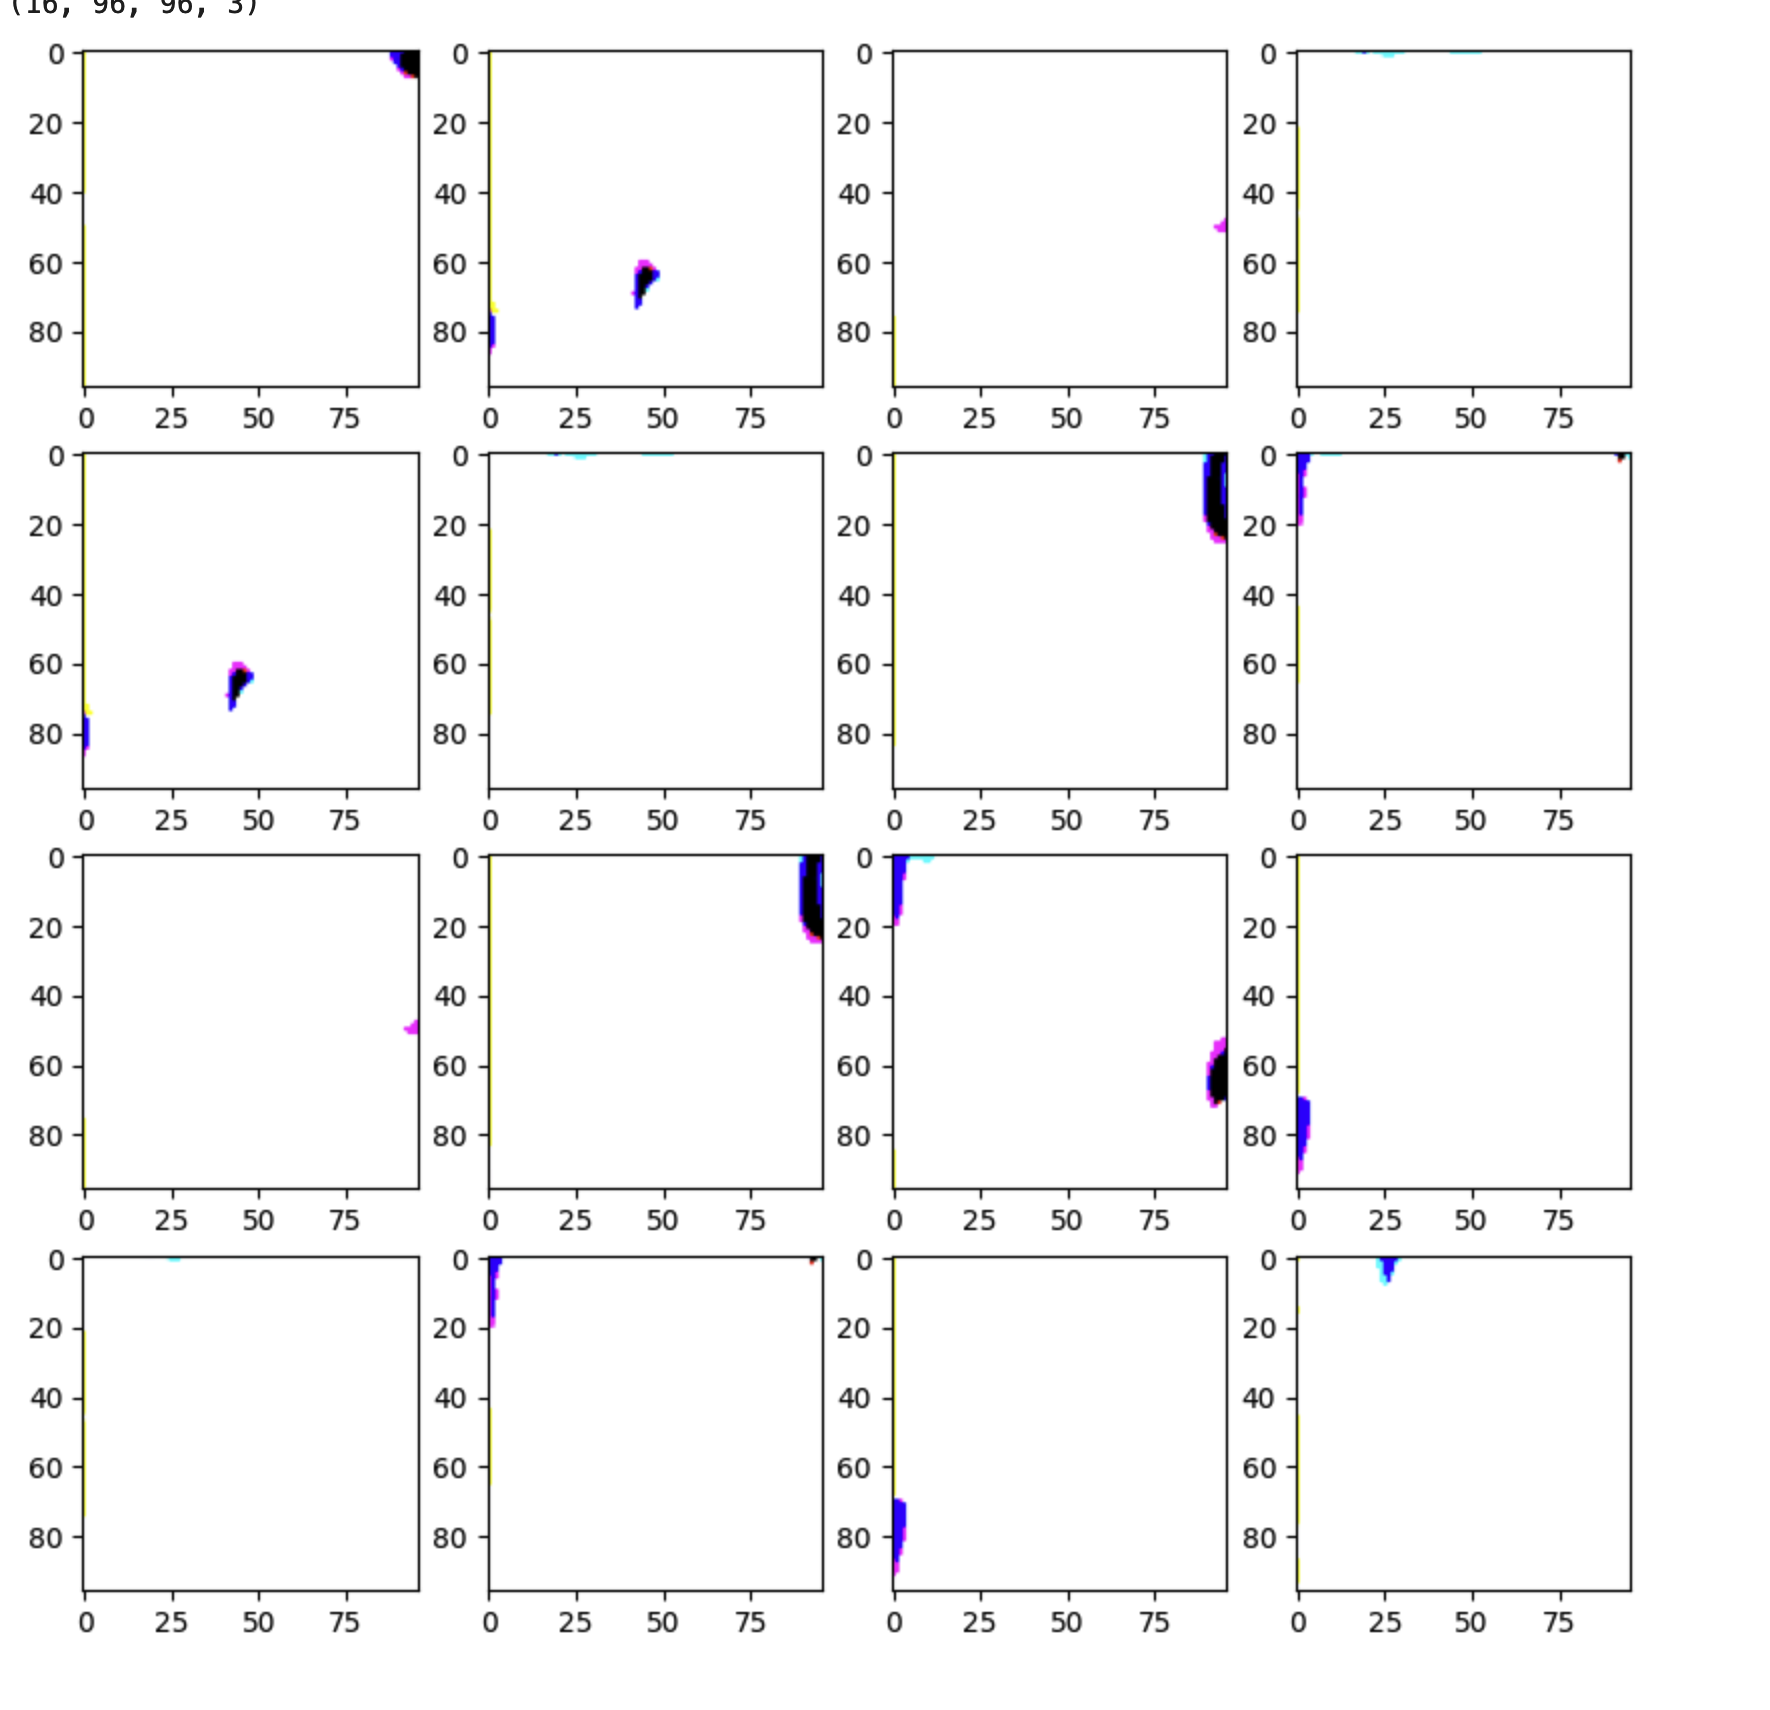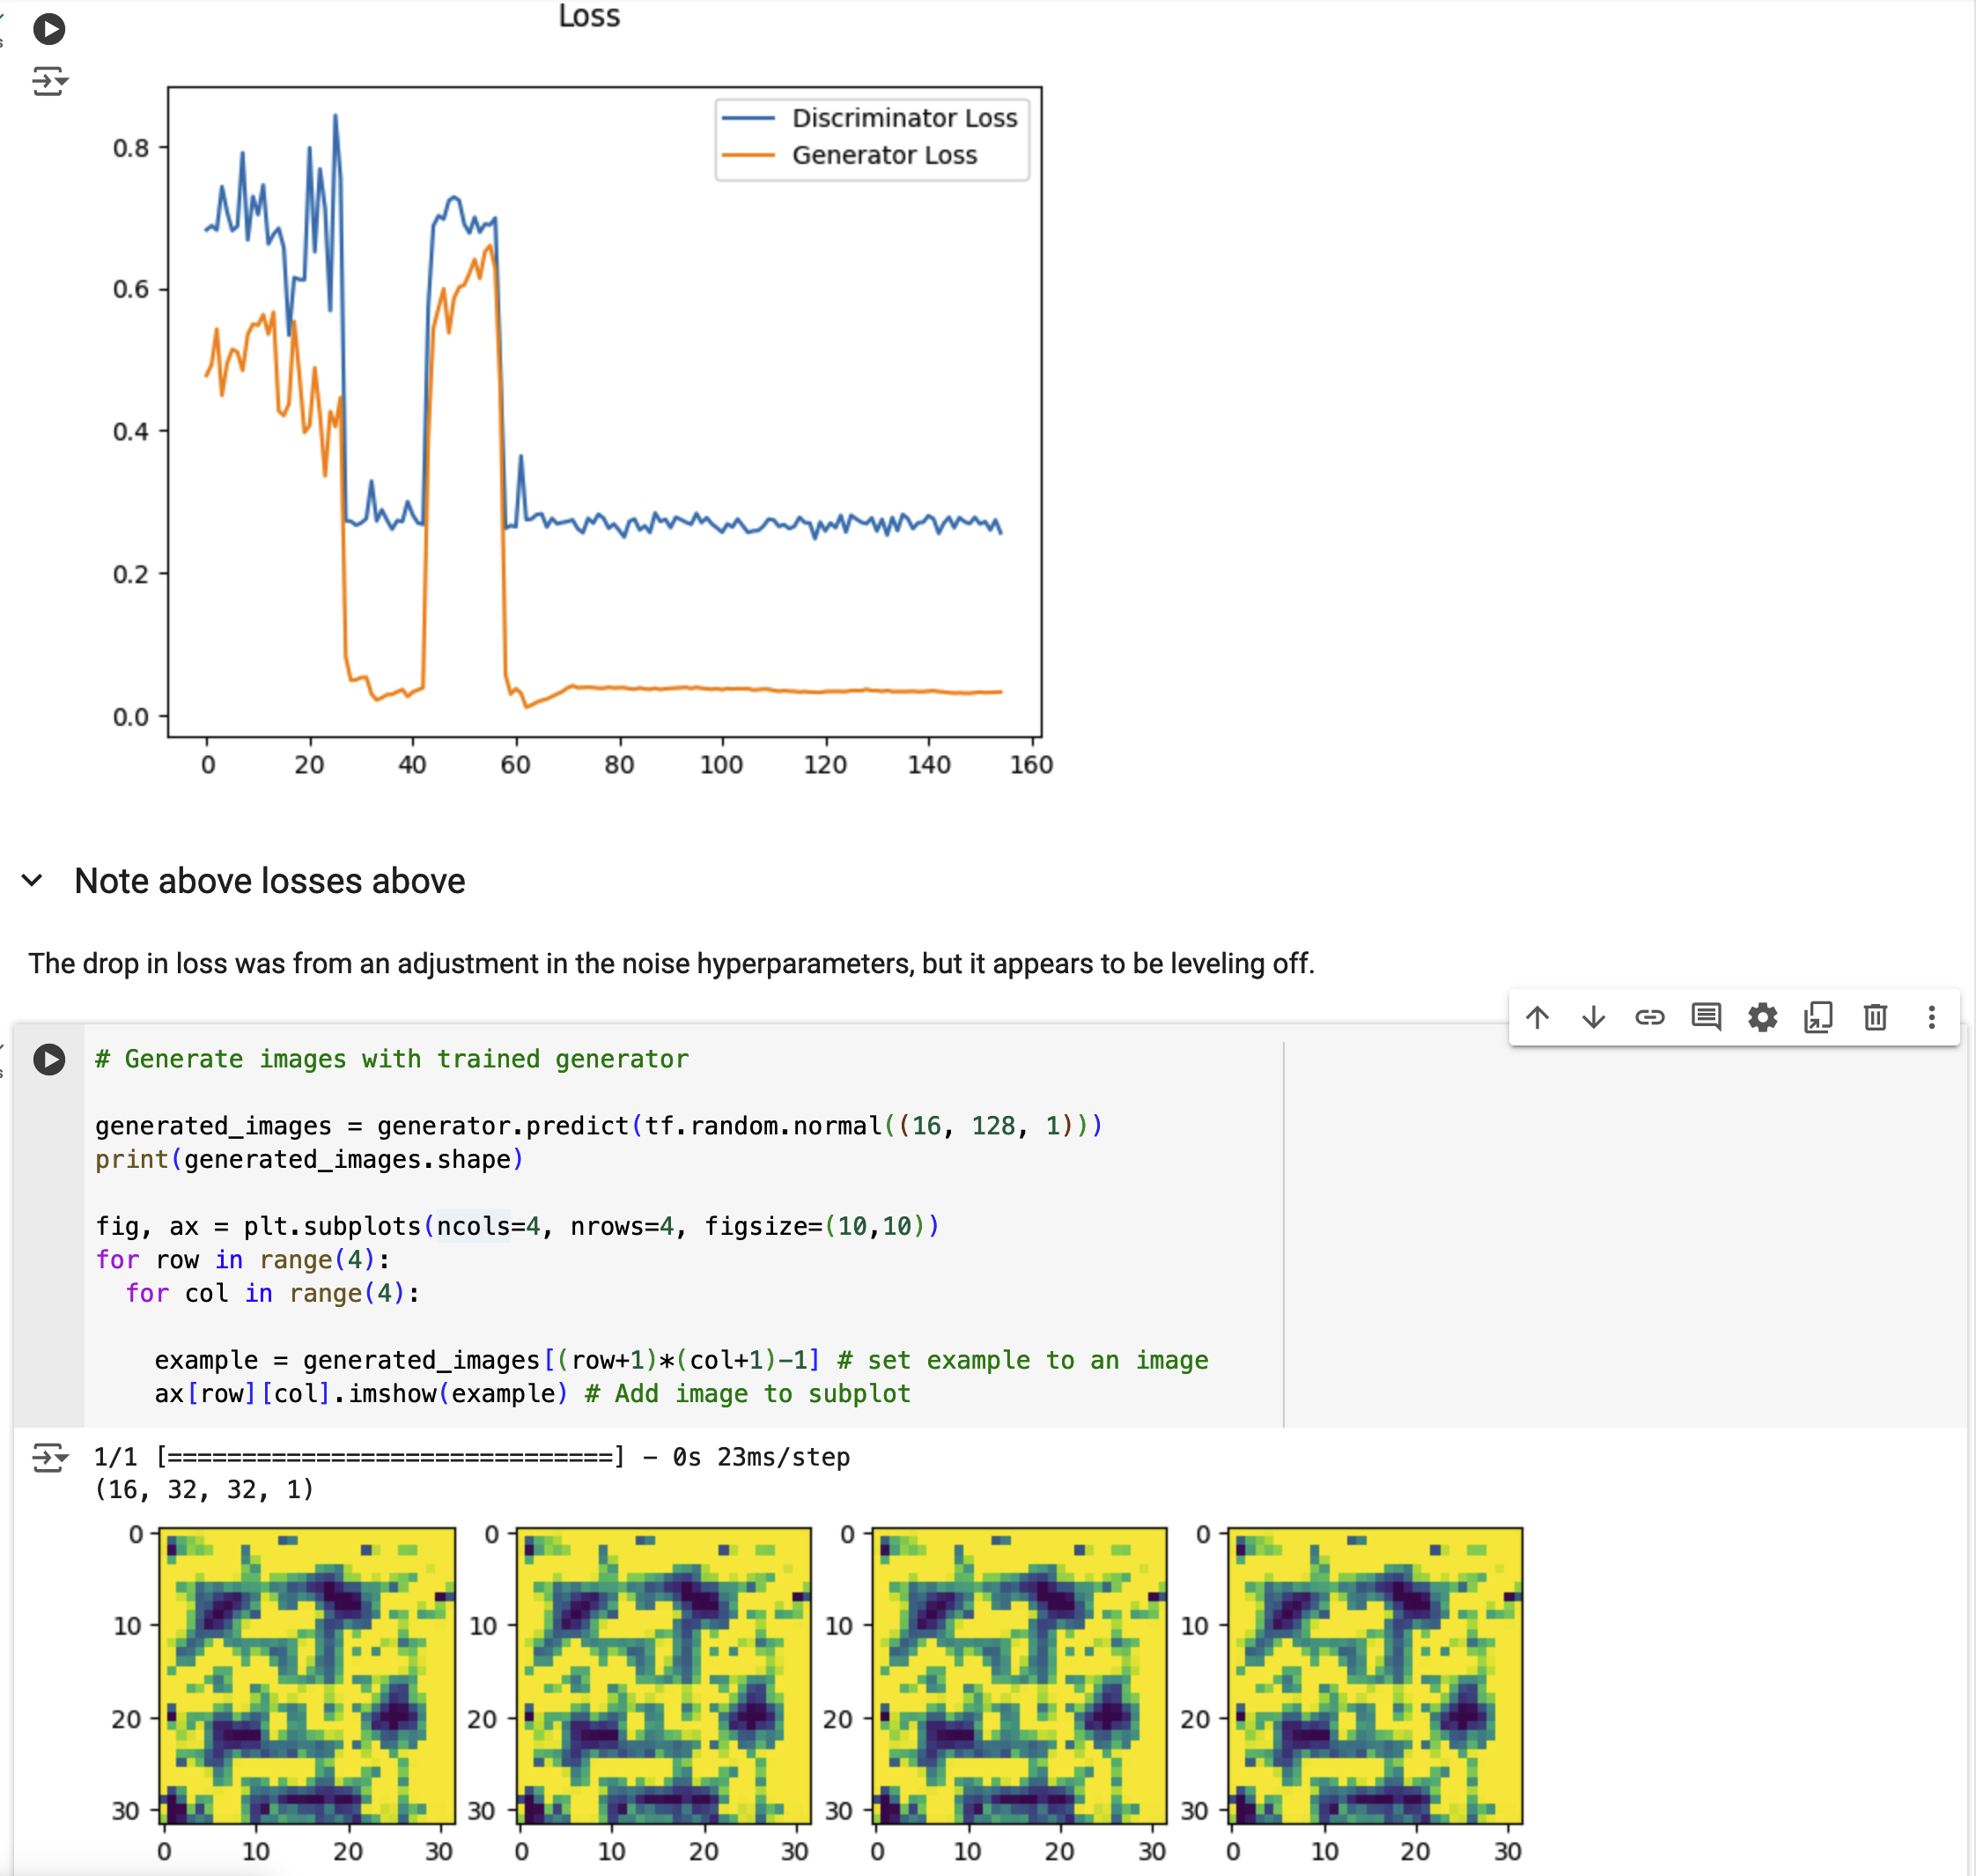

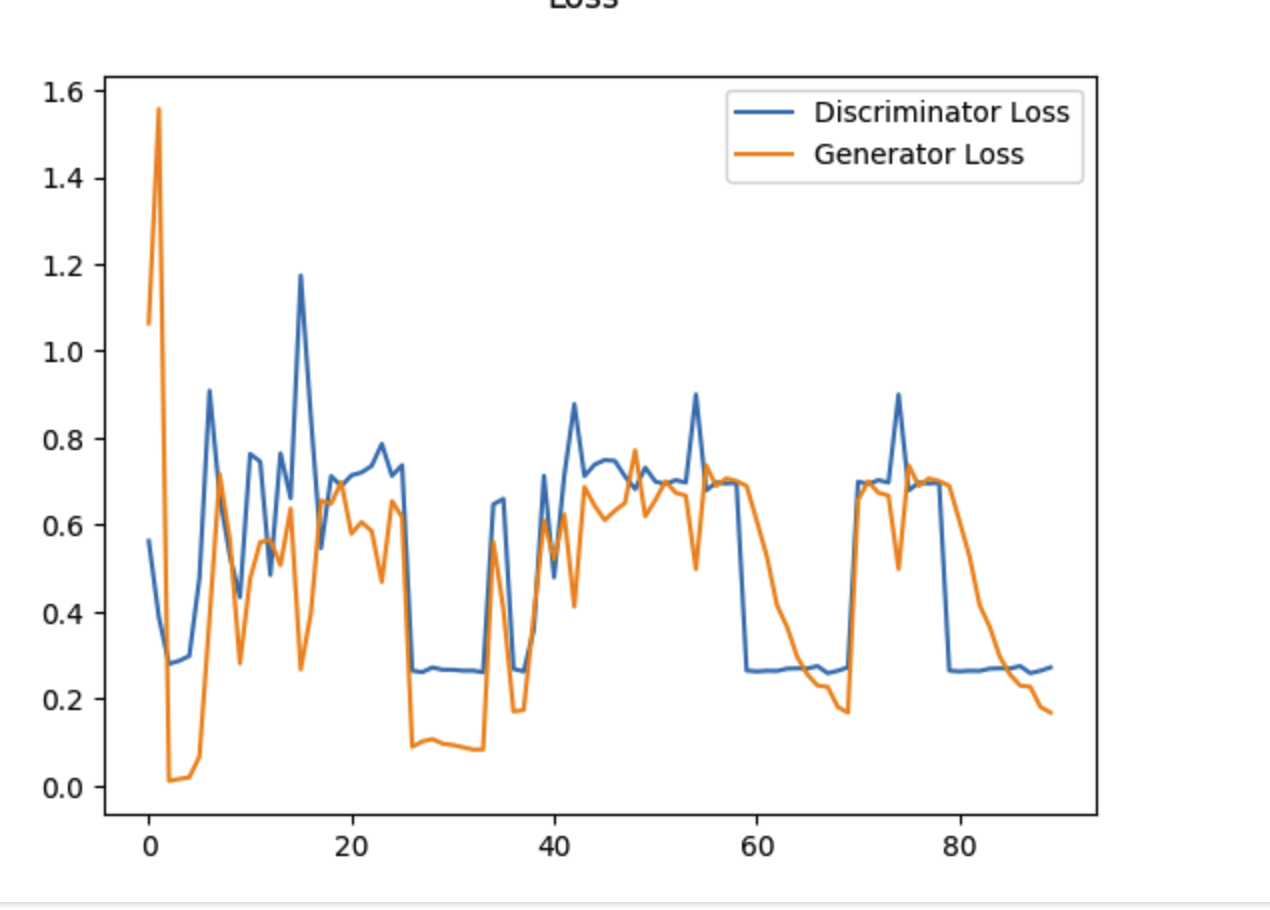